### Imports

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, Flatten, Dropout
from typing import Iterable, Union
from toggle import hide_toggle
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from get_data import get_training, get_test
from learning import fit, evaluate, plot_history
from plots import plot_features, plot_compare_features


from numpy.random import seed
seed(9849)
from tensorflow import set_random_seed
set_random_seed(6432)

hide_toggle()

In [2]:
def create_model(sample_shape: Iterable,
                 no_classes: int, kernel1:Iterable, kernel2:Iterable, conv_filt: int, dense_filt: int,
                 optimizer = 'adam', loss_fun = 'binary_crossentropy'):
    model = Sequential()
    model.add(Conv2D(conv_filt, kernel_size = kernel1,input_shape=sample_shape, activation='relu', data_format = 'channels_last'))
    model.add(AveragePooling2D(kernel2))
    model.add(Dropout(0.5))
    model.add(Dense(dense_filt, activation='relu')) #kolejne relu
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(no_classes, activation='softmax'))
    model.compile(loss=loss_fun, optimizer=optimizer, metrics=['accuracy'])
    return model

# Loading data

In [3]:
dire = "./npy_data/"
dire = "./npy_data2/"
# dire = "./npy_data3/"

class_no8 = np.load(dire+'class_no8.npy')
data_no8 = np.load(dire+'data_no8.npy')


class_no13 = np.load(dire+'class_no13.npy')
data_no13 = np.load(dire+'data_no13.npy')

class_no18 = np.load(dire+'class_no18.npy')
data_no18 = np.load(dire+'data_no18.npy')

class_no23 = np.load(dire+'class_no23.npy')
data_no23 = np.load(dire+'data_no23.npy')

class_no28 = np.load(dire+'class_no28.npy')
data_no28 = np.load(dire+'data_no28.npy')

class_no33 = np.load(dire+'class_no33.npy')
data_no33 = np.load(dire+'data_no33.npy')

hide_toggle()

## Picture options - time x freq bands or time x channels

In [7]:
freq_bands = 'ijkl->jlik' #better
channels = 'ijkl->jlki'
option = freq_bands

## Prepared combinations

In [9]:
X = {1 : data_no13, 2: data_no18, 3: data_no23, 4: data_no28, 5: data_no33}
y = {1 : class_no13, 2: class_no18, 3: class_no23, 4: class_no28, 5: class_no33}
combinations_train = ((1,2,3,4),
                      (1,2,3,5),
                      (1,2,4,5),
                      (1,3,4,5),
                      (2,3,4,5))

combinations_test = (5, 4, 3, 2, 1)

### Params

In [10]:
batch_size = 200
no_epochs = 20
verbosity = 1
loss_fun = 'binary_crossentropy'

## Datasets

In [17]:
combination = 1

'''Train'''
X_train, y_train = get_training(X, y, combinations_train[combination], option)

'''Test'''
X_test, y_test = get_test(X, y, combinations_test[combination], option)

'''Validation'''
X_validation = np.einsum(option,data_no8)
y_validation = to_categorical(class_no8).astype(int)


'''Cutting edges'''
X_train = X_train[:,5:71,:,:]
X_test = X_test[:,5:71,:,:]
X_validation = X_validation[:,5:71,:,:]

sample_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])


In [18]:
X_validation.shape[0] + X_test.shape[0] + X_train.shape[0]

29911

## Learning

In [19]:
"Creating model"
model = create_model(sample_shape, 2, (11,1), (11,1), 8, 40, optimizer='adam')

"Fitting model to data"
fitted_model, hist = fit(model, X_train, y_train, X_test, y_test, 
            batch_size, no_epochs)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 18086 samples, validate on 4508 samples
Epoch 1/20
18086/18086 [==============================] - 2s 96us/sample - loss: 0.7102 - acc: 0.5065 - val_loss: 0.6918 - val_acc: 0.5180
Epoch 2/20
18086/18086 [==============================] - 2s 84us/sample - loss: 0.6952 - acc: 0.5170 - val_loss: 0.6881 - val_acc: 0.5508
Epoch 3/20
18086/18086 [==============================] - 2s 85us/sample - loss: 0.6921 - acc: 0.5297 - val_loss: 0.6855 - val_acc: 0.5626
Epoch 4/20
18086/18086 [==============================] - 2s 85us/sample - loss: 0.6887 - acc: 0.5391 - val_loss: 0.6834 - val_acc: 0.5732
Epoch 5/20
18086/18086 [==============================] - 2s 83us/sample - loss: 0.6875 - acc: 0.5471 - val_loss: 0.6845 - val_acc: 0.5612
Epoch 6/20
18086/18086 [==============================] - 2s 84us/sample - loss: 

## Evaluating

Test loss: 0.6803041719113019 / Test accuracy: 0.5767390727996826


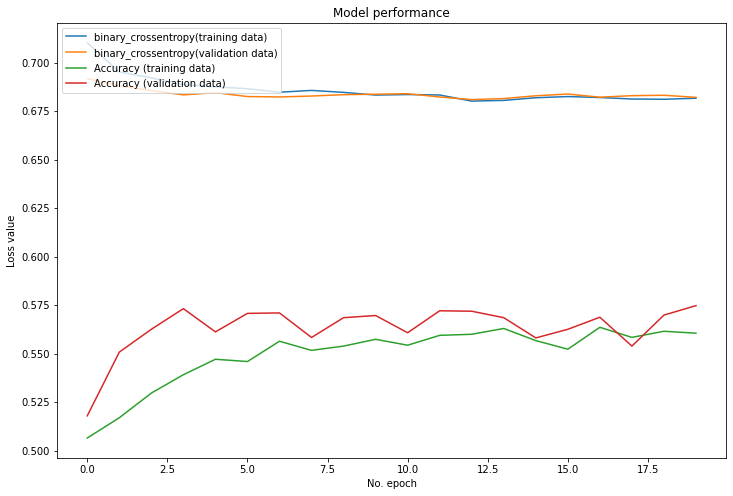

In [20]:
"Getting validation and loss score"
score = evaluate(fitted_model, X_validation, y_validation)

"Plotting history"
plot_history(hist, loss_fun)

# Filters visualization

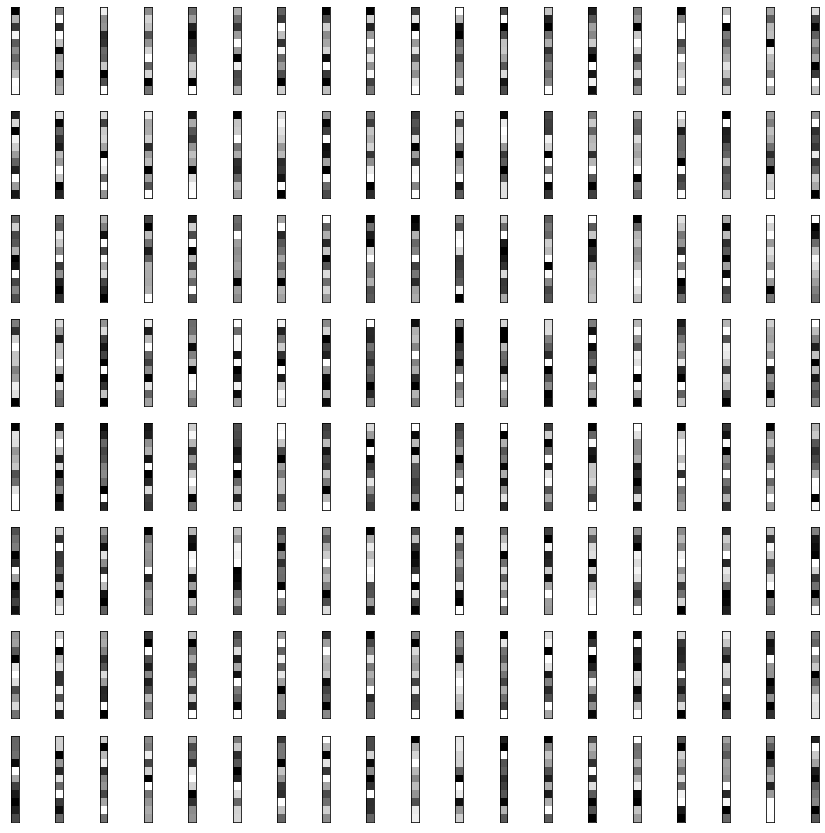

In [22]:
from matplotlib import pyplot

filters, biases = fitted_model.layers[0].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
n_filters, ix = 8, 1
pyplot.figure(figsize = (15,15))
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(19):
        # specify subplot and turn of axis
        ax = pyplot.subplot(n_filters, 19, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure
pyplot.show()

# Feature map visualization

In [23]:
filters = 8
outputs = [fitted_model.layers[0].output]
model = Model(inputs=fitted_model.inputs, outputs=outputs)

### Feature map for one example

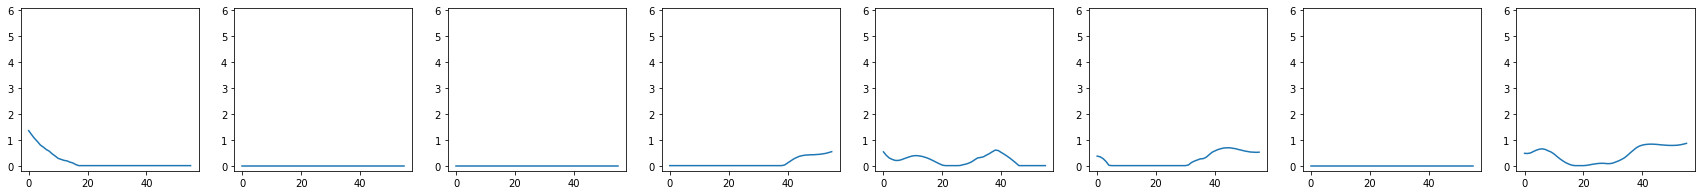

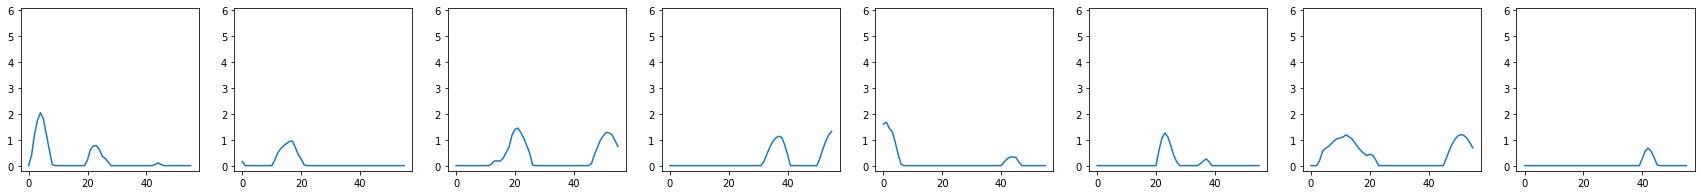

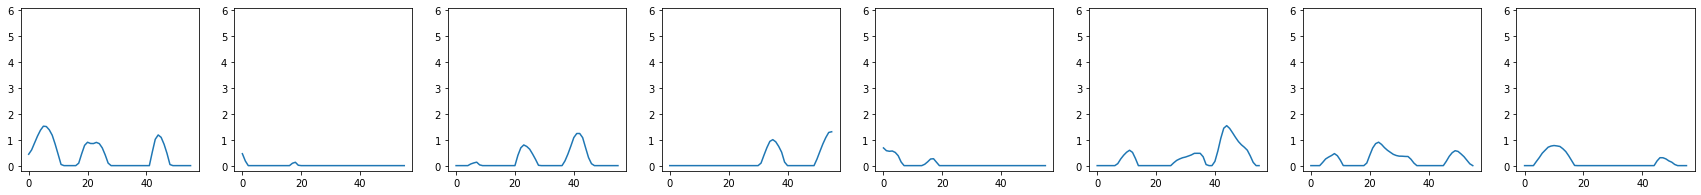

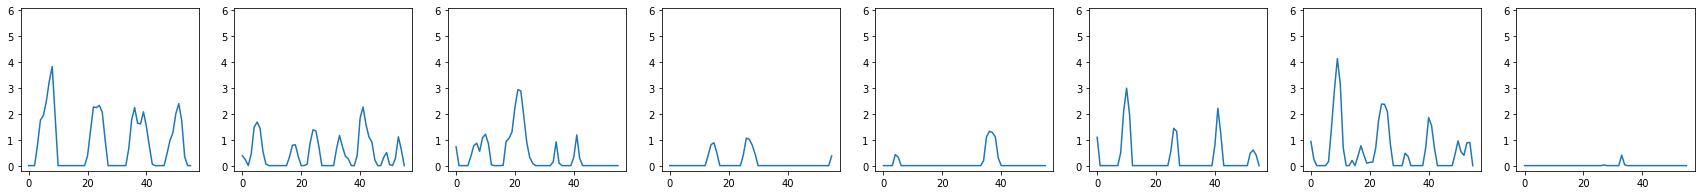

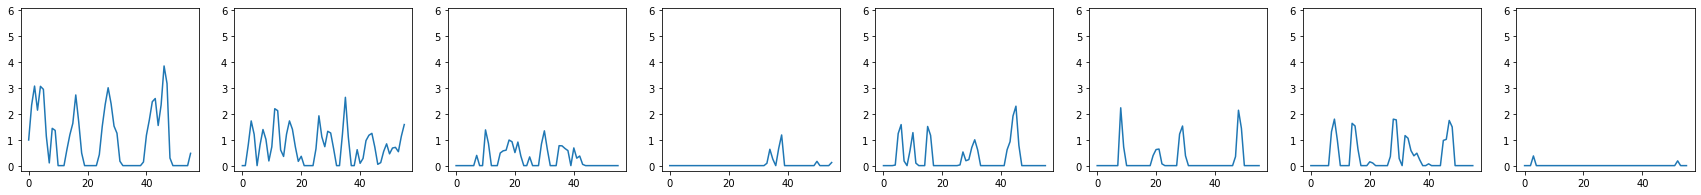

In [24]:
feature_maps = model.predict(np.expand_dims(X_validation[2],axis=0))

for i in range(5):
    pyplot.figure(figsize = (30,3))
    for x in range(filters):
        ax = pyplot.subplot(1, 8, x+1)
        pyplot.ylim(-0.2,6.1)
        pyplot.plot(feature_maps[0, :, i, x])
        ix += 1
    pyplot.show()#Podpisać osie - pasma, czas itp

# Mean maps

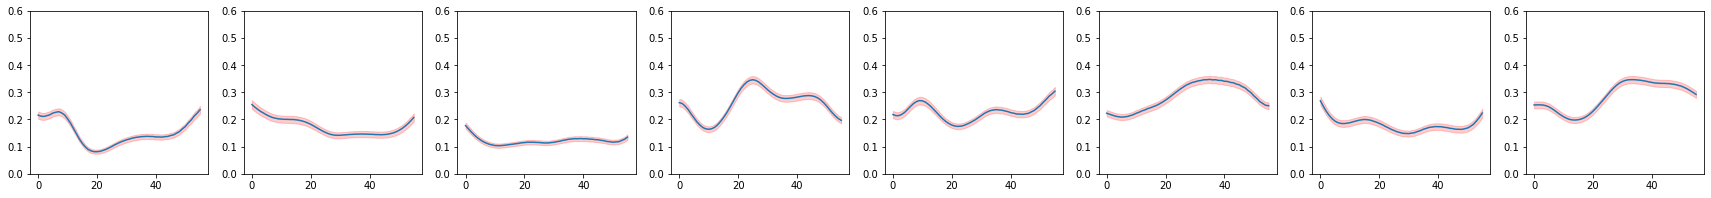

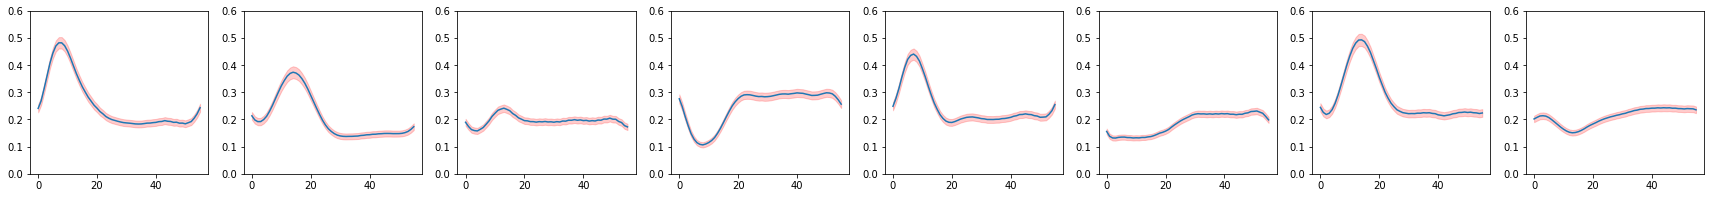

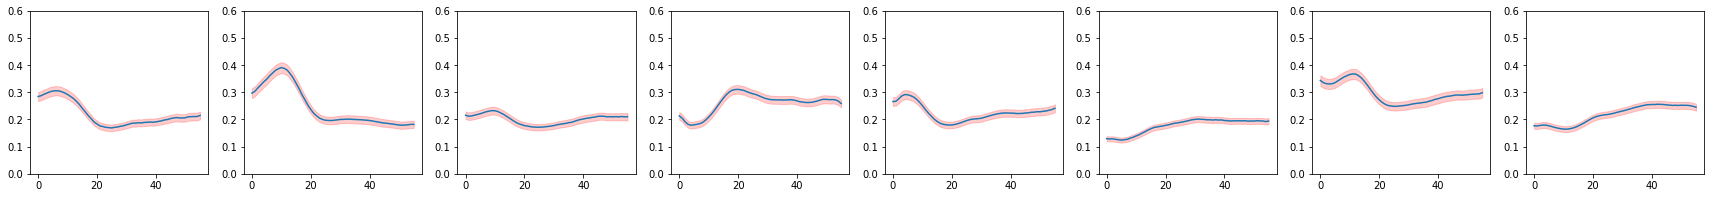

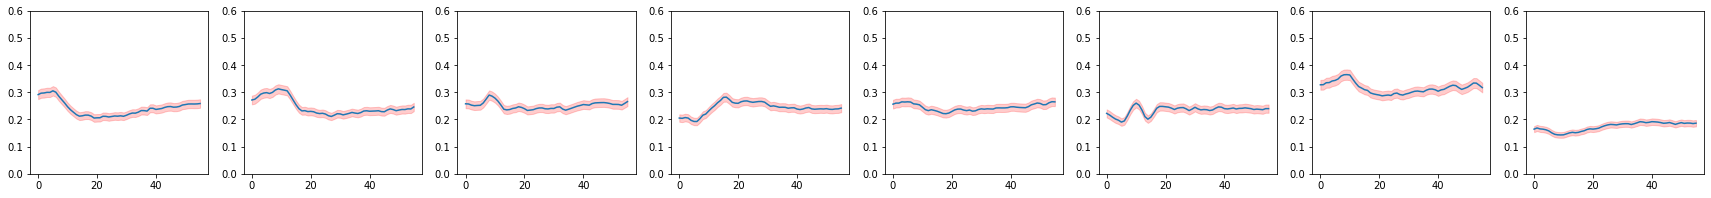

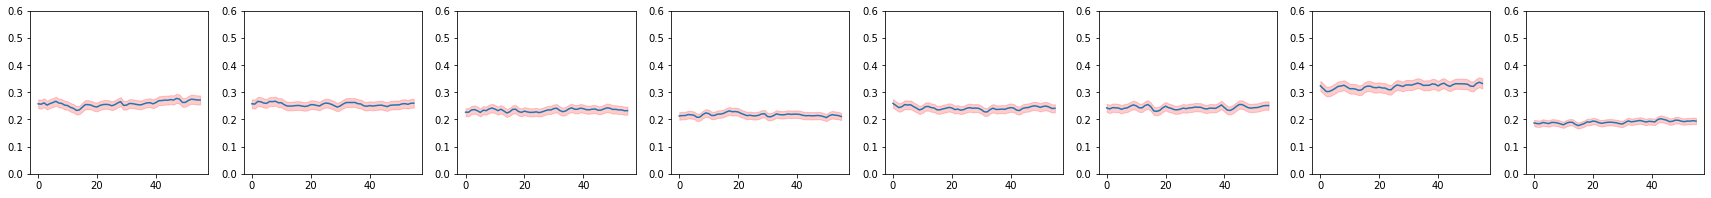

In [43]:
feature_maps = model.predict(X_validation)
plot_features(feature_maps, filters, (0,0.6))

## Dobrze sklasyfikowane

In [28]:
features_maps = model.predict(X_validation)
ind_good = np.where(fitted_model.predict_classes(X_validation) == class_no8)[0]
features_good = features_maps[ind_good]

## Źle sklasyfikowane

In [29]:
features_maps = model.predict(X_validation)
ind_bad = np.where(fitted_model.predict_classes(X_validation) != class_no8)[0]
features_bad = features_maps[ind_bad]

In [47]:
plot_compare_features(features_good, features_bad, filters, (0,0.5))

TypeError: plot_compare_features() takes 3 positional arguments but 4 were given

## Wśród poprawnie zaklasyfikowancyh kategoria 0

In [179]:
features = model.predict(X_validation)
ind_good = np.where(fitted_model.predict_classes(X_validation) == class_no8)[0]
ind_good1 = np.where(class_no8 == 1)[0]
ind_good1 = np.unique(np.concatenate((ind_good, ind_good1)))
ind_good2 = np.where(class_no8 == 0)[0]
ind_good2 = np.unique(np.concatenate((ind_good, ind_good2)))

features_good = features[ind_good]
features_good1 = features[ind_good1]
features_good2 = features[ind_good2]

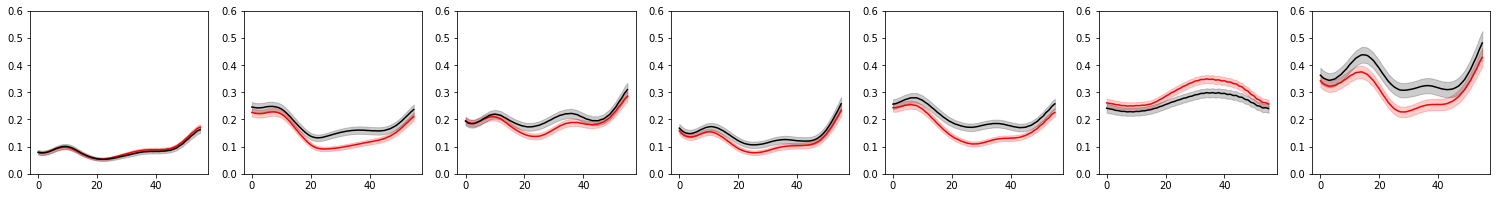

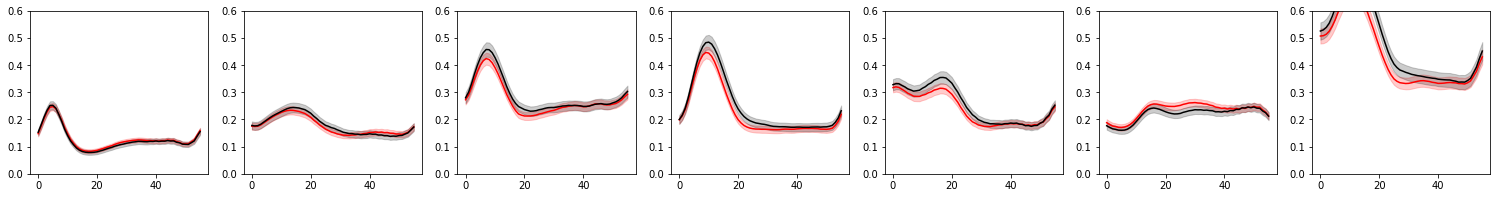

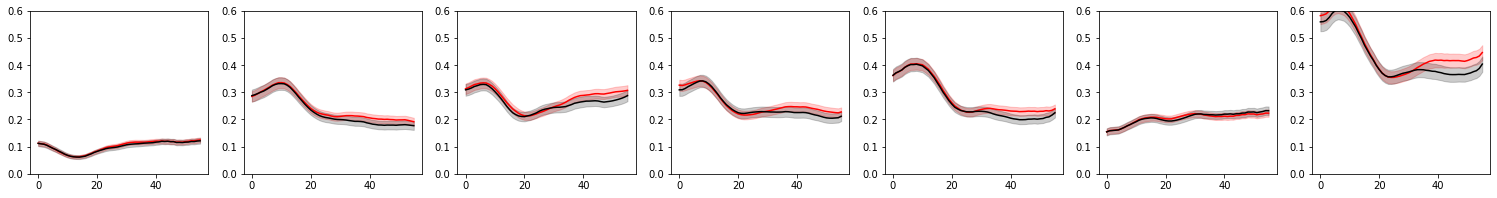

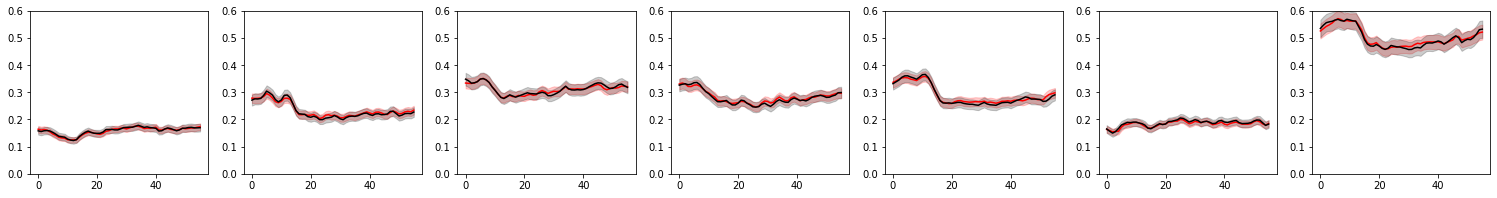

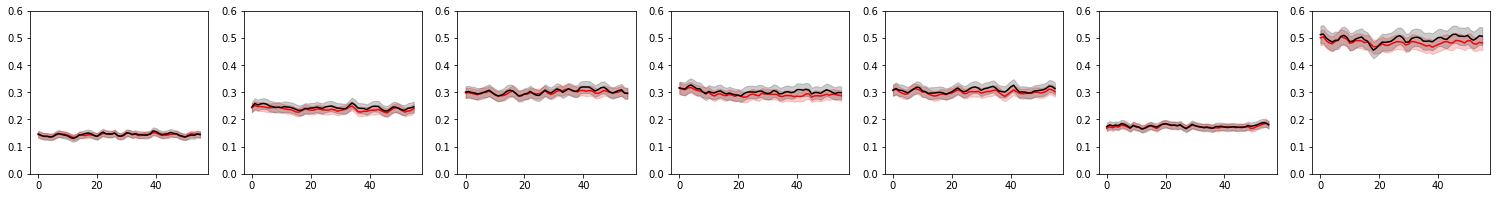

In [180]:
plot_compare_features(features_good1, features_good2, filters)

In [58]:
#zasłanianie kolejnych fragmentów/pasm i sprw. walidacji (accuracy), można kanały zerować (najlepiej wartość stałą (średnia ze wszystkich?), nie nie brać)
#Macierz pasma x kanały - accuracy/zmianę accuracy (różnicę accuracy od "bazowego") - na raz wyłączam pasmo i dany kanał
#waliduje na sieci nauczonej całymi danymi
#5 sieci - zebrać taką macierz dla każdej i uśrednić (zapisać sobie dla obrazowania) pickle np.

## Collecting votes

In [60]:
part = np.load(dire+'participants.npy')
print(part[:8])
print(part[8:13])
print(part[13:18])
print(part[18:23])
print(part[23:28])
print(part[28:33])
print(combinations_train[2])

['m17' 'k10' 'm16' 'k11' 'm6' 'k14' 'm10' 'k7']
['m11' 'm5' 'm7' 'm1' 'm18']
['k5' 'm15' 'k18' 'k3' 'm14']
['m13' 'm2' 'k16' 'k6' 'm9']
['k4' 'm8' 'm12' 'm3' 'k15']
['k12' 'k13' 'k8' 'k9' 'm4']
(1, 2, 4, 5)


In [102]:
X_validation = np.einsum(option,data_no8)
y_validation = to_categorical(class_no8).astype(int)

In [103]:
X_validation = X_validation[:,5:71,:,:]
X_validation.shape

(7317, 66, 5, 19)

In [105]:
batch_size = 200
no_epochs = 10

trials = y_validation.shape[0]
pred = np.zeros((5,trials))

for i in range(5):
    X_train, y_train = get_training(X, y, combinations_train[i], option)
    X_test, y_test = get_test(X, y, combinations_test[i], option)
    X_train = X_train[:,5:71,:,:]
    X_test = X_test[:,5:71,:,:]
    sample_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

    model = create_model(sample_shape, 2, (66,1),(1,1), 20, 40)
    
    fitted_model, _ = fit(model, X_train, y_train, X_test, y_test, 
                batch_size, no_epochs, verbosity = 1)
    fitted_model.save('./models/model2_'+str(i))

    "Getting validation and loss score"
    score = evaluate(fitted_model, X_validation, y_validation)
    pred[i] = fitted_model.predict_classes(X_validation)
    print(i)
votes = np.sum(pred, axis = 0)
votes[votes<=2] = 0
votes[votes>=3] = 1
score = len(votes[class_no8==votes])
acc = score/trials
print(acc)

Train on 17869 samples, validate on 4725 samples
Epoch 1/10
17869/17869 [==============================] - 1s 76us/sample - loss: 0.7270 - acc: 0.5025 - val_loss: 0.6946 - val_acc: 0.5198
Epoch 2/10
17869/17869 [==============================] - 1s 64us/sample - loss: 0.6982 - acc: 0.5336 - val_loss: 0.6900 - val_acc: 0.5403
Epoch 3/10
17869/17869 [==============================] - 1s 62us/sample - loss: 0.6901 - acc: 0.5416 - val_loss: 0.6885 - val_acc: 0.5374
Epoch 4/10
17869/17869 [==============================] - 1s 63us/sample - loss: 0.6854 - acc: 0.5526 - val_loss: 0.6864 - val_acc: 0.5511
Epoch 5/10
17869/17869 [==============================] - 1s 64us/sample - loss: 0.6801 - acc: 0.5670 - val_loss: 0.6878 - val_acc: 0.5537
Epoch 6/10
17869/17869 [==============================] - 1s 64us/sample - loss: 0.6746 - acc: 0.5740 - val_loss: 0.6859 - val_acc: 0.5486
Epoch 7/10
17869/17869 [==============================] - 1s 63us/sample - loss: 0.6732 - acc: 0.5815 - val_loss: 0.6

In [107]:
# replacement = ( np.mean(X_train, axis = 0) + np.mean(X_test, axis = 0) ) / 2
replacement = np.mean(X_validation, axis = 0)
# prediction = np.empty((5,5,19,trials))
acc_score = np.empty((5,5,19))
for i in range(5):
    model = load_model('./models/model2_'+str(i))
    for band in range(5):
        for ch in range(19):
            X_temp = X_validation.copy()
            X_temp[:,:,band,ch] = replacement[:,band,ch]
            score = evaluate(model, X_temp, y_validation)
            acc_score[i,band,ch] = score[1]
#             prediction[i,band,ch,:] = model.predict_classes(X_temp)
            print(f'model = {i}, band = {band}, channel ={ch}')
    print('FINISHED MODEL ' + str(i))

Test loss: 0.6835736616299389 / Test accuracy: 0.552275538444519
model = 0, band = 0, channel =0
Test loss: 0.684234726098256 / Test accuracy: 0.5529588460922241
model = 0, band = 0, channel =1
Test loss: 0.6847563490558717 / Test accuracy: 0.5458521246910095
model = 0, band = 0, channel =2
Test loss: 0.6827603263071005 / Test accuracy: 0.552275538444519
model = 0, band = 0, channel =3
Test loss: 0.6826883193914464 / Test accuracy: 0.5521388649940491
model = 0, band = 0, channel =4
Test loss: 0.6839738987631626 / Test accuracy: 0.5555555820465088
model = 0, band = 0, channel =5
Test loss: 0.6833107581111891 / Test accuracy: 0.5539155602455139
model = 0, band = 0, channel =6
Test loss: 0.6834160239787412 / Test accuracy: 0.5540522336959839
model = 0, band = 0, channel =7
Test loss: 0.6830927536137951 / Test accuracy: 0.552275538444519
model = 0, band = 0, channel =8
Test loss: 0.6831567463969963 / Test accuracy: 0.5529588460922241
model = 0, band = 0, channel =9
Test loss: 0.68268205939

Test loss: 0.6830474058428602 / Test accuracy: 0.5539155602455139
model = 0, band = 4, channel =8
Test loss: 0.6837999271421106 / Test accuracy: 0.5559655427932739
model = 0, band = 4, channel =9
Test loss: 0.6829616241202876 / Test accuracy: 0.5569222569465637
model = 0, band = 4, channel =10
Test loss: 0.6832705656573373 / Test accuracy: 0.5540522336959839
model = 0, band = 4, channel =11
Test loss: 0.6830088354466928 / Test accuracy: 0.554325520992279
model = 0, band = 4, channel =12
Test loss: 0.6833079518296932 / Test accuracy: 0.5540522336959839
model = 0, band = 4, channel =13
Test loss: 0.6829147246653906 / Test accuracy: 0.5571955442428589
model = 0, band = 4, channel =14
Test loss: 0.6838481193995141 / Test accuracy: 0.5540522336959839
model = 0, band = 4, channel =15
Test loss: 0.6836079853764156 / Test accuracy: 0.5541888475418091
model = 0, band = 4, channel =16
Test loss: 0.6832878526335322 / Test accuracy: 0.5559655427932739
model = 0, band = 4, channel =17
Test loss: 0.

Test loss: 0.6862947073190675 / Test accuracy: 0.5571955442428589
model = 1, band = 3, channel =16
Test loss: 0.6854139233899765 / Test accuracy: 0.5599289536476135
model = 1, band = 3, channel =17
Test loss: 0.685728184476615 / Test accuracy: 0.5591089129447937
model = 1, band = 3, channel =18
Test loss: 0.6861004104652707 / Test accuracy: 0.5561022162437439
model = 1, band = 4, channel =0
Test loss: 0.6850261578260752 / Test accuracy: 0.5608856081962585
model = 1, band = 4, channel =1
Test loss: 0.6857182543118404 / Test accuracy: 0.5606122612953186
model = 1, band = 4, channel =2
Test loss: 0.6855597249777636 / Test accuracy: 0.5586988925933838
model = 1, band = 4, channel =3
Test loss: 0.6854512305619435 / Test accuracy: 0.5586988925933838
model = 1, band = 4, channel =4
Test loss: 0.6855144349541742 / Test accuracy: 0.5622522830963135
model = 1, band = 4, channel =5
Test loss: 0.6852886931759682 / Test accuracy: 0.5619789361953735
model = 1, band = 4, channel =6
Test loss: 0.68561

Test loss: 0.6839375576882377 / Test accuracy: 0.5634822845458984
model = 2, band = 3, channel =5
Test loss: 0.6829767415998281 / Test accuracy: 0.5608856081962585
model = 2, band = 3, channel =6
Test loss: 0.6830959575284092 / Test accuracy: 0.5641656517982483
model = 2, band = 3, channel =7
Test loss: 0.683367930500335 / Test accuracy: 0.5632089376449585
model = 2, band = 3, channel =8
Test loss: 0.6833463559405504 / Test accuracy: 0.5634822845458984
model = 2, band = 3, channel =9
Test loss: 0.6833183206429455 / Test accuracy: 0.5633456110954285
model = 2, band = 3, channel =10
Test loss: 0.6833996453115128 / Test accuracy: 0.5645756721496582
model = 2, band = 3, channel =11
Test loss: 0.6833069844944516 / Test accuracy: 0.5656690001487732
model = 2, band = 3, channel =12
Test loss: 0.6837133019042501 / Test accuracy: 0.5648489594459534
model = 2, band = 3, channel =13
Test loss: 0.6833149260944791 / Test accuracy: 0.5617055892944336
model = 2, band = 3, channel =14
Test loss: 0.683

Test loss: 0.6875204992242177 / Test accuracy: 0.5488588213920593
model = 3, band = 2, channel =13
Test loss: 0.6877049128752157 / Test accuracy: 0.5485854744911194
model = 3, band = 2, channel =14
Test loss: 0.6875052648488658 / Test accuracy: 0.5487221479415894
model = 3, band = 2, channel =15
Test loss: 0.6878679916395 / Test accuracy: 0.5492688417434692
model = 3, band = 2, channel =16
Test loss: 0.6873438191231408 / Test accuracy: 0.5521388649940491
model = 3, band = 2, channel =17
Test loss: 0.6873988066603288 / Test accuracy: 0.5507721900939941
model = 3, band = 2, channel =18
Test loss: 0.6877519123065793 / Test accuracy: 0.5500888228416443
model = 3, band = 3, channel =0
Test loss: 0.6866155379258725 / Test accuracy: 0.5529588460922241
model = 3, band = 3, channel =1
Test loss: 0.6878474864279359 / Test accuracy: 0.5451687574386597
model = 3, band = 3, channel =2
Test loss: 0.6872804640371388 / Test accuracy: 0.5465354919433594
model = 3, band = 3, channel =3
Test loss: 0.6869

Test loss: 0.6883584972253601 / Test accuracy: 0.5496788024902344
model = 4, band = 2, channel =2
Test loss: 0.6882773212140516 / Test accuracy: 0.5465354919433594
model = 4, band = 2, channel =3
Test loss: 0.6883077413409855 / Test accuracy: 0.5477654933929443
model = 4, band = 2, channel =4
Test loss: 0.6880187068755174 / Test accuracy: 0.5488588213920593
model = 4, band = 2, channel =5
Test loss: 0.6879937713452827 / Test accuracy: 0.5498154759407043
model = 4, band = 2, channel =6
Test loss: 0.6881765169948767 / Test accuracy: 0.5465354919433594
model = 4, band = 2, channel =7
Test loss: 0.6880898605820845 / Test accuracy: 0.5503621697425842
model = 4, band = 2, channel =8
Test loss: 0.6880363980016699 / Test accuracy: 0.5514554977416992
model = 4, band = 2, channel =9
Test loss: 0.6877488505568223 / Test accuracy: 0.5494055151939392
model = 4, band = 2, channel =10
Test loss: 0.6880455645964871 / Test accuracy: 0.5465354919433594
model = 4, band = 2, channel =11
Test loss: 0.68796

In [108]:
# np.save('predictions.npy',prediction)
np.save('acc_score2.npy',acc_score)

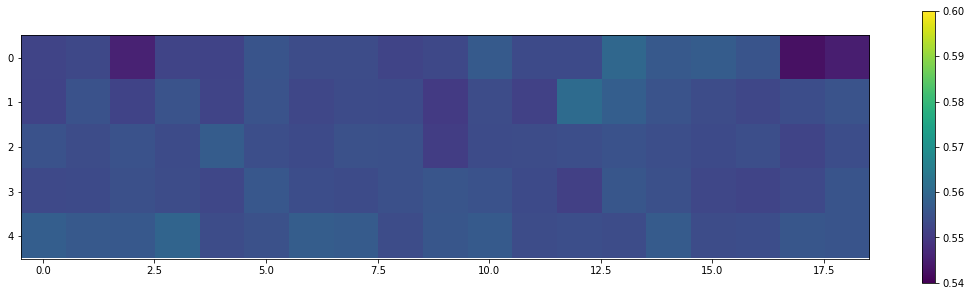

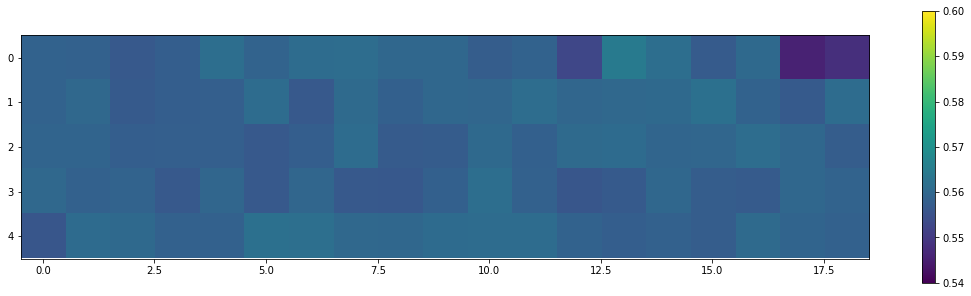

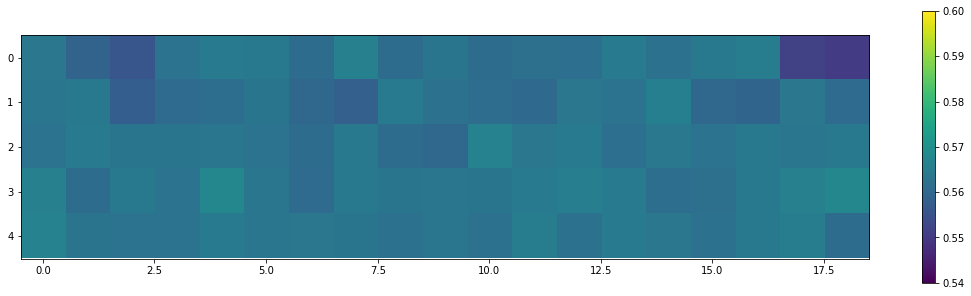

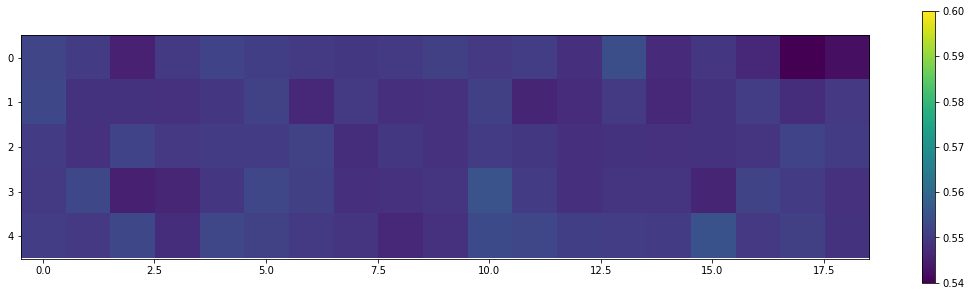

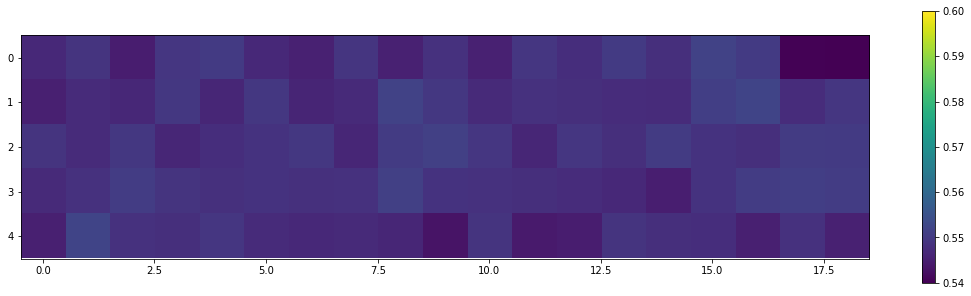

In [109]:
for i in range(5):
    plt.figure(figsize = (19,5))
    plt.imshow(acc_score[i])
    plt.clim(0.54,0.6)
    plt.colorbar()
    plt.show()

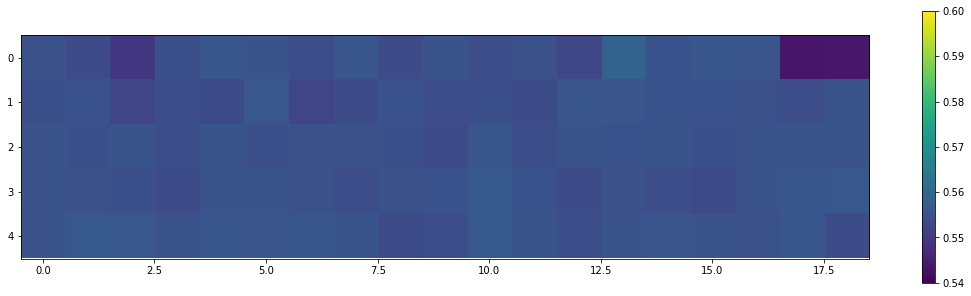

In [110]:
plt.figure(figsize = (19,5))
plt.imshow(np.mean(acc_score, axis=0))
plt.clim(0.54,0.6)
plt.colorbar()
plt.show()

In [78]:
chan = np.load('channels.npy')

In [81]:
chan[17]

'Fp1'

# OKLUZJA

In [113]:
replacement = ( np.mean(X_train, axis = 0) + np.mean(X_test, axis = 0) ) / 2

In [115]:
acc_score = np.empty((5,19))

In [87]:
batch_size = 200
no_epochs = 10

trials = y_validation.shape[0]
pred = np.zeros((5,19,trials))

for band in range(5):
    for ch in range(19):
        X_train, y_train = get_training(X, y, combinations_train[0], option)
        X_test, y_test = get_test(X, y, combinations_test[0], option)
        sample_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]) 
        X_train[:,:,band,ch] = replacement[:,band,ch]
        X_test[:,:,band,ch] = replacement[:,band,ch]
        model = create_model(sample_shape, 2, (7,1),(7,1), 20, 40)

        fitted_model, _ = fit(model, X_train, y_train, X_test, y_test, 
                                batch_size, no_epochs, verbosity = 0)
        fitted_model.save(.s/model0_B'+str(band)+'CH'+str(ch))

        "Getting validation and loss score"
        score = evaluate(fitted_model, X_validation, y_validation)
        acc_score[band,ch] = score[1]
        pred[band,ch,:] = fitted_model.predict_classes(X_validation)

(77,)